# Install Libraries

In [ ]:
!pip install tensorflow pandas numpy sklearn
!pip install pandas scikit-learn
!pip install lime shap
!pip install imbalanced-learn

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from imblearn.under_sampling import ClusterCentroids, NearMiss, AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, CondensedNearestNeighbour, NeighbourhoodCleaningRule, OneSidedSelection
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.metrics import AUC, Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, auc

# Read Preprocessed Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path_AU_preprocessed = '/content/drive/MyDrive/CKD/Finalised/data/preprocessed/AU/AU_preprocessed_df.csv'
file_path_JP_preprocessed = '/content/drive/MyDrive/CKD/Finalised/data/preprocessed/JP/JP_preprocessed_df.csv'

# Feature Engineering - AU Dataset

In [ ]:
# Compute slope
def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        #print(group['ID'])
        return 0.0

    return LinearRegression().fit(x, y).coef_[0]

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def process_au_dataframe(file_path):
    AU_df = pd.read_csv(file_path)
    AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
    AU_df = AU_df.reset_index(drop=True)

    # Convert 'COLLECTED' to float for calculation purposes
    AU_df['COLLECTED'] = AU_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID'
    grouped = AU_df.groupby('ID')

    # Compute slopes for each group and directly assign them to the DataFrame
    AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']

    # Calculate mean and std for eGFR
    AU_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    AU_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    AU_df.fillna(0, inplace=True)

    return AU_df

In [ ]:
# Apply to AU dataset to obtain final features
AU_df = process_au_dataframe(file_path_AU_preprocessed)
AU_df = AU_df.drop_duplicates(subset='ID', keep='last')
AU_df = AU_df.reset_index()
AU_df.drop(columns=['index', 'COLLECTED', 'ID'], inplace=True)
AU_df

<ipython-input-6-bca0dc4c2494>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


,SEX,AGE,eGFR,Kidney_Failure,eGFR_slope,eGFR_mean,eGFR_std
0,1,46,17,1,-0.045462,18.055556,2.099642
1,1,69,81,0,0.009469,64.375000,13.968715
2,2,83,81,0,0.375050,68.500000,11.445523
3,2,70,91,0,0.033512,84.083333,12.336647
4,1,83,16,0,-0.169529,32.380952,6.566554
...,...,...,...,...,...,...,...
10059,2,81,41,0,1.649853,40.000000,2.708013
10060,1,69,39,0,-0.415541,55.400000,13.277801
10061,1,72,64,0,3.841912,60.666667,3.511885
10062,1,84,50,0,-2.396167,52.666667,2.516611


# Feature Engineering - JP Dataset

In [ ]:
# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

# Compute slope
def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    model = LinearRegression().fit(x, y)
    return model.coef_[0]

def process_dataframe(file_path):
    JP_df = pd.read_csv(file_path)
    JP_df = JP_df.reset_index(drop=True)

    # Apply the function to the 'Time' column to create a new 'Months' column
    JP_df['Months'] = JP_df['Time'].apply(convert_to_months)

    # Assume a starting date for all IDs
    start_date = pd.Timestamp('2020-01-01')

    # Create a 'COLLECTED' column based on the 'Months' column
    JP_df['COLLECTED'] = JP_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

    # Convert 'COLLECTED' to float for calculation purposes
    JP_df['COLLECTED'] = JP_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID' and calculate slopes, mean, and std for eGFR
    grouped = JP_df.groupby('ID')
    JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']
    JP_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    JP_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    JP_df.fillna(0, inplace=True)

    return JP_df

In [ ]:
# Apply to JP dataset to obtain final features
JP_df = process_dataframe(file_path_JP_preprocessed)
JP_df = JP_df.drop_duplicates(subset='ID', keep='last')
JP_df = JP_df.reset_index()
JP_df.drop(columns=['index', 'COLLECTED', 'ID'], inplace=True)
JP_df

<ipython-input-8-3cd75912c9d2>:41: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


,SEX,Time,AGE,eGFR,Kidney_Failure,Months,eGFR_slope,eGFR_mean,eGFR_std
0,2,eGFR(last visit),77,22.501266,0,42,-0.015137,29.643276,7.328739
1,1,eGFR(last visit),63,31.122497,0,42,-0.000594,32.782173,2.383736
2,2,eGFR(last visit),67,52.723521,0,42,0.009158,48.577456,8.327068
3,1,eGFR(last visit),81,28.367088,0,42,-0.023434,45.492439,11.840661
4,1,eGFR(last visit),75,59.473437,0,42,0.000127,58.290224,1.683767
...,...,...,...,...,...,...,...,...,...
592,1,eGFR(last visit),78,17.544560,0,42,-0.005829,19.248703,3.447072
593,2,eGFR(last visit),69,55.024770,0,42,0.008088,49.596328,5.243989
594,1,eGFR(last visit),84,20.203155,0,42,-0.011671,25.153274,6.111866
595,1,eGFR(last visit),63,54.572415,0,42,-0.001015,58.403641,3.721187


# Cluster-based Undersampling applied to AU Dataset

## Undersample

In [ ]:
from imblearn.under_sampling import ClusterCentroids

# Define features and target variable
features = ['SEX', 'AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean']
X = AU_df[features]
y = AU_df['Kidney_Failure']
print(y.value_counts())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply ClusterCentroids based undersampling
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X_scaled, y)

print(y_cc.value_counts())

# Re-assign features and target
X = X_cc
y = y_cc

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    9711
1     353
Name: Kidney_Failure, dtype: int64
0    353
1    353
Name: Kidney_Failure, dtype: int64


## Evaluate Random Forest on AU Dataset

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best seed: 1
Best seed's performance metrics:
Accuracy: 0.9263 (± 0.0097)
Precision: 0.9289 (± 0.0080)
Recall: 0.9235 (± 0.0213)
F1_Score: 0.9260 (± 0.0104)
Specificity: 0.9292 (± 0.0089)
Mean ROC AUC: 0.9769 (± 0.0044)
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


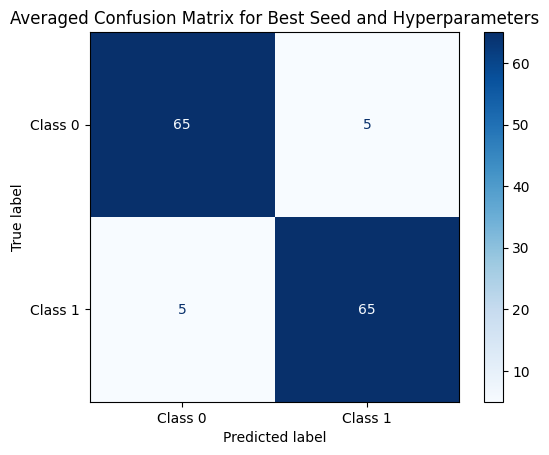

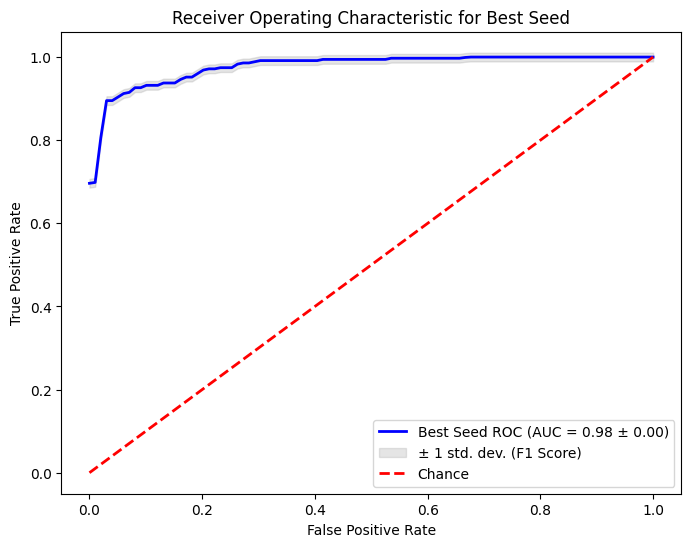

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Define the scoring dictionary
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

# Parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Seeds to loop over
seed_values = range(6)  # Adjust the range as needed

# Initialize accumulators for ROC curve data
mean_fpr = np.linspace(0, 1, 100)
seed_results = []

# Loop over seeds
for seed_value in seed_values:
    random.seed(seed_value)
    np.random.seed(seed_value)

    # Initialize a Decision Tree model
    clf = RandomForestClassifier(random_state=seed_value)

    # Initialize GridSearch
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value),
                               scoring=scoring, n_jobs=-1, verbose=1, refit='f1_score')

    # Fit the GridSearch model
    grid_search.fit(X, y)

    # Extract the best estimator
    best_clf = grid_search.best_estimator_

    # Initialize accumulators for metrics, ROC curve data, and confusion matrix components
    fold_metrics = []
    fold_tprs = []
    fold_aucs = []
    cm_components = []

    # Use Stratified KFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train using the best estimator
        best_clf.fit(X_train, y_train)

        # Get predicted probabilities for the positive class
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # Compute confusion matrix and metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Store CM components for each fold
        cm_components.append((tn, fp, fn, tp))

        # Calculate metrics using confusion matrix components
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        fold_metrics.append({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
                             'F1_Score': f1, 'Specificity': specificity, 'ROC_AUC': roc_auc})

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        fold_tprs.append(np.interp(mean_fpr, fpr, tpr))
        fold_aucs.append(roc_auc)

    # Store the metrics, ROC data, and confusion matrix components
    seed_results.append({
        'seed': seed_value,
        'metrics': fold_metrics,
        'tprs': fold_tprs,
        'aucs': fold_aucs,
        'params': grid_search.best_params_,
        'cm_components': cm_components
    })

# ------------

# Find the best seed based on the highest mean F1 score
mean_f1_scores = [np.mean([fm['F1_Score'] for fm in res['metrics']]) for res in seed_results]
best_seed_idx = np.argmax(mean_f1_scores)
best_seed_data = seed_results[best_seed_idx]

# Calculate the mean and standard deviation for metrics and AUC for the best seed
mean_metrics = {metric: np.mean([m[metric] for m in best_seed_data['metrics']]) for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'Specificity']}
std_metrics = {metric: np.std([m[metric] for m in best_seed_data['metrics']]) for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'Specificity']}

# Calculate the mean AUCs for the best seed
mean_auc = np.mean(best_seed_data['aucs'])
std_auc = np.std(best_seed_data['aucs'])

# Calculate the mean TPRs for the best seed
mean_tpr = np.mean(best_seed_data['tprs'], axis=0)
mean_tpr[-1] = 1.0 # Ensure it ends at 1.0

# ------------

# Print the best seed's performance metrics
print(f"Best seed: {best_seed_data['seed']}")
print("Best seed's performance metrics:")
for metric, value in mean_metrics.items():
  print(f"{metric}: {value:.4f} (± {std_metrics[metric]:.4f})")
print(f"Mean ROC AUC: {mean_auc:.4f} (± {std_auc:.4f})")
print("Best Hyperparameters:", best_seed_data['params'])

# ------------

# Average the confusion matrix components for the best seed
avg_cm_components = np.mean(best_seed_data['cm_components'], axis=0).astype(int)
avg_cm = np.array([[avg_cm_components[0], avg_cm_components[1]], [avg_cm_components[2], avg_cm_components[3]]])

# Display the averaged confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=['Class 0', 'Class 1'])
cm_display.plot(cmap='Blues')
plt.title('Averaged Confusion Matrix for Best Seed and Hyperparameters')
plt.show()

# ------------

# Plotting the ROC curve for the best seed
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Best Seed ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
plt.fill_between(mean_fpr, mean_tpr - std_metrics['F1_Score'], mean_tpr + std_metrics['F1_Score'], color='grey', alpha=0.2, label=r'± 1 std. dev. (F1 Score)')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Best Seed')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import pickle

data_to_export = {
    'mean_fpr': mean_fpr,
    'mean_tpr': mean_tpr,
    'mean_auc': mean_auc,
    'std_auc': std_auc,
    'model_name': 'Random Forest'  # Change this for each model
}

# Exporting to a pickle file
with open(f'{data_to_export["model_name"]}_roc_data.pkl', 'wb') as file:
    pickle.dump(data_to_export, file)


## Retrain Random Forest on the Entire AU Dataset

In [ ]:
# Extract the best hyperparameters for the model
best_seed = best_seed_data['seed']
best_params = best_seed_data['params']
print("Best Hyperparameters:", best_params)

# Reinitialize the model with the best parameters
best_model = RandomForestClassifier(**best_params, random_state=best_seed)

# Retrain the model on the entire dataset
best_model.fit(X, y)

Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_features='auto',
                       min_samples_split=10, random_state=1)


# Transfer learning with JP Data (without fine-tuning on 15% subset)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import clone

# Using the already trained best_model
clf = best_model

# Dataset features and target
features = ['SEX', 'AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean']
X_test = JP_df[features]
y_test = JP_df['Kidney_Failure']

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
threshold = 0.5

# Convert X_test DataFrame to NumPy array if necessary
#X_test_np = X_test_scaled.values  # Convert DataFrame to NumPy array

# Evaluate on the held-out test set
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)  # Applying threshold

# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate metrics manually using confusion matrix components
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Model performance on the test set:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Specificity: {specificity}")

Model performance on the test set:
Accuracy: 0.7386934673366834
Precision: 0.5714285714285714
Recall (Sensitivity): 0.14814814814814814
F1 Score: 0.23529411764705882
ROC AUC: 0.7943025400879806
Specificity: 0.9586206896551724


# Transfer Learning with JP Dataset (fine-tuning on 15% subset)

## Find the best seed

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best seed: 26
Best seed's performance metrics:
TN                  332
FP                   38
FN                   24
TP                  114
Accuracy       0.877953
Precision          0.75
Recall         0.826087
F1_Score       0.786207
ROC_AUC        0.928153
Specificity    0.897297
Name: 26, dtype: object


<ipython-input-15-e982770c4127>:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Class 0', 'Class 1'])
<ipython-input-15-e982770c4127>:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['Class 0', 'Class 1'])


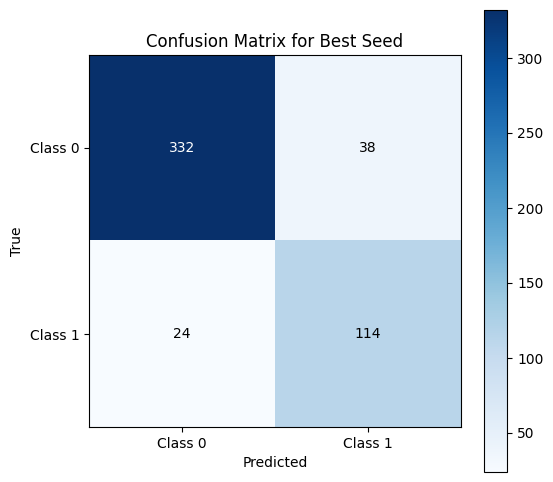

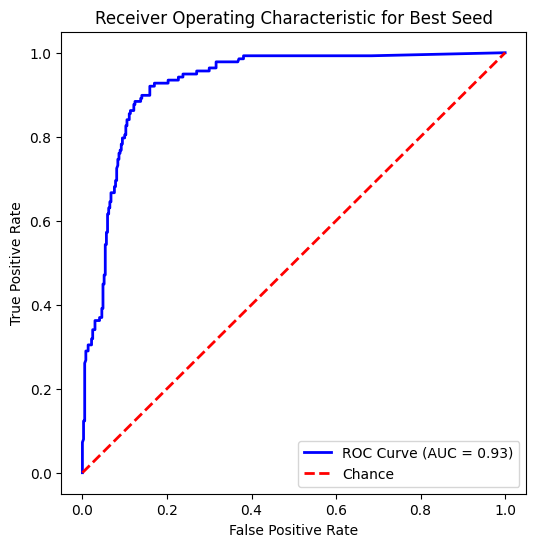

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

threshold = 0.5

# Dataset features and target
features = ['SEX', 'AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean']
X = JP_df[features]
y = JP_df['Kidney_Failure']

X_scaled = scaler.fit_transform(X)

# List to store results
results_list = []

# Accumulators for ROC curve data
tprs = []
mean_fpr = np.linspace(0, 1, 100)
aucs = []

for seed_value in range(50):  # Example: 50 different seeds
    random.seed(seed_value)
    np.random.seed(seed_value)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.85, random_state=seed_value, stratify=y)

    # Clone the best model to avoid cumulative fitting
    clf = clone(best_model)
    clf.fit(X_train, y_train)

    # Evaluate on the held-out test set
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)  # Applying threshold

    # Compute the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate metrics manually using confusion matrix components
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Append the results including fpr, tpr for ROC curve
    results_list.append({
        'Seed': seed_value,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'ROC_AUC': roc_auc,
        'Specificity': specificity,
        'FPR': fpr,
        'TPR': tpr
    })

# Convert results list to DataFrame
df_results = pd.DataFrame(results_list)

# Find the best seed based on the highest F1 Score
best_seed_row = df_results.loc[df_results['F1_Score'].idxmax()]
best_seed = int(best_seed_row['Seed'])
best_fpr = best_seed_row['FPR']
best_tpr = best_seed_row['TPR']
best_roc_auc = best_seed_row['ROC_AUC']

# Print the best seed and its performance
print(f"Best seed: {best_seed}")
print("Best seed's performance metrics:")
print(best_seed_row[['TN', 'FP', 'FN', 'TP', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC', 'Specificity']])

# ------------------

# Plotting the confusion matrix for the best seed
cm = np.array([[best_seed_row['TN'], best_seed_row['FP']], [best_seed_row['FN'], best_seed_row['TP']]]).astype(int)
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Best Seed')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['Class 0', 'Class 1'])
ax.set_yticklabels([''] + ['Class 0', 'Class 1'])
# Set labels to be at the bottom
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.grid(False)
for i in range(2):
    for j in range(2):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

# ------------------

# Plotting the ROC curve for the best seed
plt.figure(figsize=(6, 6))
plt.plot(best_fpr, best_tpr, color='blue', label=f'ROC Curve (AUC = {best_roc_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Best Seed')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle

data_to_export = {
    'best_fpr': best_fpr,
    'best_tpr': best_tpr,
    'best_roc_auc': best_roc_auc,
    'model_name': 'Random Forest JP'  # Change this for each model
}

# Exporting to a pickle file
with open(f'{data_to_export["model_name"]}_roc_data.pkl', 'wb') as file:
    pickle.dump(data_to_export, file)

# END